<a href="https://colab.research.google.com/github/O-Kpy/Kaggle/blob/main/tabular_playground_series_oct_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle --upgrade

import os
import zipfile

os.environ['KAGGLE_USERNAME'] = 'kjohhhhh'
os.environ['KAGGLE_KEY'] = '341f64ea938cee8360311d433f05de02'

!kaggle competitions download -c tabular-playground-series-oct-2021

!unzip 'sample_submission.csv.zip'
!unzip 'test.csv.zip'
!unzip 'train.csv.zip'

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
submit = pd.read_csv('/content/sample_submission.csv')
train.shape, test.shape

((1000000, 287), (500000, 286))

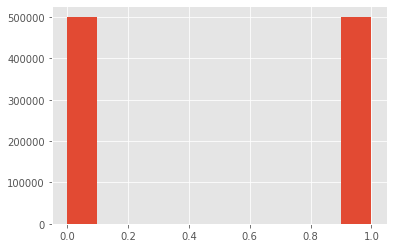

In [ ]:
train.target.hist()

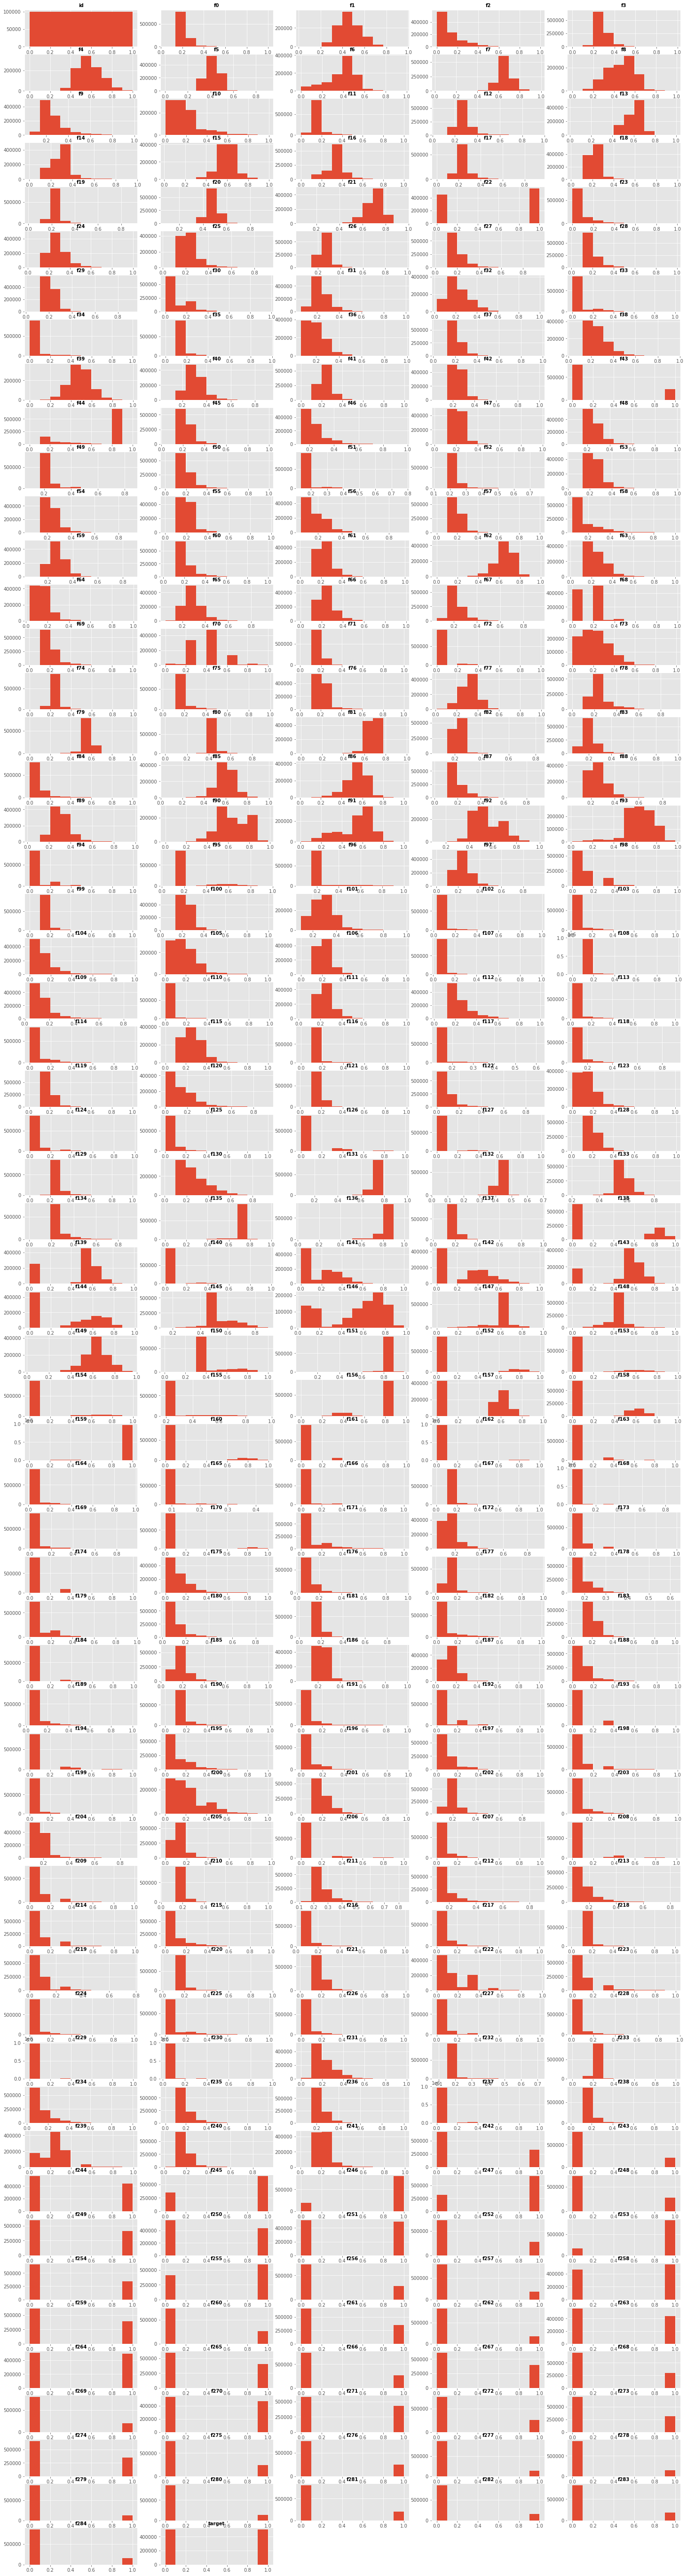

In [ ]:
plt.figure(figsize=(25, 100))
for i, j in enumerate(train.columns):
  plt.subplot(58, 5, i+1)
  plt.hist(train[j])
  plt.title(f'{j}', fontsize=10, fontweight='bold')

In [ ]:
!pip install catboost
!pip install optuna

In [ ]:
import catboost
import optuna
import xgboost
import lightgbm
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
x_train = train.drop(columns=['target', 'id'])
y_train = train['target']
x_test = test.drop(columns=['id'])

x_train_columns = x_train.columns
x_test_columns = x_test.columns

In [ ]:
cat_cols = [col for col in x_train.columns if x_train[col].nunique() < 3]

In [ ]:
x_train[cat_cols] = x_train[cat_cols].astype('object')
x_test[cat_cols] = x_test[cat_cols].astype('object')

In [ ]:
# for i in x_train.select_dtypes(exclude=['object']):
  # sc = StandardScaler().fit(x_train[[i]])

  # x_train[i] = sc.transform(x_train[[i]])
  # x_test[i] = sc.transform(x_test[[i]])

sc = StandardScaler().fit(x_train)
x_train = pd.DataFrame(sc.transform(x_train), columns=x_train_columns)
x_test = pd.DataFrame(sc.transform(x_test), columns=x_test_columns)

In [ ]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Columns: 285 entries, f0 to f284
dtypes: float64(285)
memory usage: 2.1 GB


# Catboost LB:85542(Non hyp tune)

In [ ]:
cat_features = list(x_train.select_dtypes('object').columns)
test_preds = 0
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for i, (train_index, valid_index) in enumerate(skf.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_cat = catboost.CatBoostClassifier(iterations=3000, learning_rate=0.02, use_best_model=True, eval_metric='AUC', task_type='GPU')
  model_cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), verbose=100, early_stopping_rounds=70)

  test_preds += model_cat.predict_proba(x_test)[:,1] / skf.n_splits

# Xgboost LB:0.85439(None hyp tune)

In [ ]:
test_preds = 0
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for i, (train_index, valid_index) in enumerate(skf.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_xgb = xgboost.XGBClassifier(n_estimators=3000, learning_rate=0.02, eval_metric='auc', tree_method='gpu_hist')
  model_xgb.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)], verbose=100, early_stopping_rounds=70)

  test_preds += model_xgb.predict_proba(x_test)[:,1] / skf.n_splits

# LightGBM LB:0.85555(None hyp tune)

In [ ]:
!git clone --recursive https://github.com/Microsoft/LightGBM
%cd /content/LightGBM

!mkdir build
!cmake -DUSE_GPU=1
!make -j$(nproc)
!sudo apt-get -y install python-pip
!sudo -H pip install setuptools pandas numpy scipy scikit-learn -U
%cd /content/LightGBM/python-package/
!sudo python setup.py install --precompile

In [ ]:
test_preds = 0
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for i, (train_index, valid_index) in enumerate(skf.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_lgb = lightgbm.LGBMClassifier(n_estimators=3000, learning_rate=0.02, metric='AUC', device='gpu')
  model_lgb.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)], verbose=100, early_stopping_rounds=70)

  test_preds += model_lgb.predict_proba(x_test)[:,1] / skf.n_splits

In [ ]:
submit = pd.read_csv('/content/sample_submission.csv')
submit['target'] = test_preds
submit.to_csv('/content/submit_oct.csv', index=False)
submit.head()

,id,target
0,1000000,0.760543
1,1000001,0.261072
2,1000002,0.892753
3,1000003,0.868312
4,1000004,0.271805


In [ ]:
import pytorch
import pytorch.nn as nn
import pytorch.optim as optim
from pytorch.optim import lr_scheduler
from pytorch.utils.data import Dataset, DataLoader